In [124]:
import os
import sys
import time
import random
import warnings
import collections
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, HalvingRandomSearchCV 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, StackingRegressor, HistGradientBoostingRegressor 
from sklearn.inspection import permutation_importance

# from sklearn.linear_model import Ridge, Lasso, BayesianRidge, ElasticNet
from sklearn.preprocessing import OneHotEncoder

sys.path.append('../src')
import cb_utils
import cb_model_utils

sns.set(style="darkgrid")
pd.options.display.max_columns = 500

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
os.getcwd()

'/Users/bp/workspace/cb/data-analytics/notebooks'

In [145]:
df = pd.read_csv('./data/uhc_tx_training_data_v2.csv')

In [146]:
df.head()

,member_id,ft_age,ft_ggroup,ft_line_of_business_id,ft_is_male,ft_nd_ip_admits,ft_hosp_los,ft_nd_er_admits,ft_nd_npi_seen,ft_nd_ndc,ft_nd_hcc,ft_hcc_list,ft_ra_coef,ft_ip_er_tc,tg_tc_12m,tg_ip_er_tc_12m,tg_er_ddos_12m,tg_ip_ddos_12m,tg_tc_1m_2m,tg_ip_er_tc_1m_2m,tg_er_ddos_1m_2m,tg_ip_ddos_1m_2m,tg_tc_1m_3m,tg_ip_er_tc_1m_3m,tg_er_ddos_1m_3m,tg_ip_ddos_1m_3m,tg_tc_1m_6m,tg_ip_er_tc_1m_6m,tg_er_ddos_1m_6m,tg_ip_ddos_1m_6m,tg_tc_2m,tg_ip_er_tc_2m,tg_er_ddos_2m,tg_ip_ddos_2m,tg_tc_3m,tg_ip_er_tc_3m,tg_er_ddos_3m,tg_ip_ddos_3m,tg_tc_6m,tg_ip_er_tc_6m,tg_er_ddos_6m,tg_ip_ddos_6m,tg_tc_9m,tg_ip_er_tc_9m,tg_er_ddos_9m,tg_ip_ddos_9m
0,252421,21,3,1,1,0,0,1,13,4,1,{74},0.339,1722.75,0.00,0.00,0,0,0.00,0.0,0,0,0.00,0.0,0,0,0.00,0.00,0,0,0.00,0.0,0,0,0.00,0.0,0,0,0.00,0.00,0,0,0.00,0.00,0,0
1,252423,55,3,1,0,0,0,2,13,107,4,"{40,59,108,111}",1.353,1853.52,35110.52,0.00,0,0,3829.83,0.0,0,0,7577.85,0.0,0,0,15416.64,0.00,0,0,8922.05,0.0,0,0,14089.47,0.0,0,0,21819.44,0.00,0,0,28232.84,0.00,0,0
2,252425,52,3,1,0,0,0,0,1,18,0,NaN,0.000,0.00,0.00,0.00,0,0,0.00,0.0,0,0,0.00,0.0,0,0,0.00,0.00,0,0,0.00,0.0,0,0,0.00,0.0,0,0,0.00,0.00,0,0,0.00,0.00,0,0
3,252427,29,3,1,0,1,57,0,3,58,5,"{18,19,85,96,135}",1.441,0.00,42151.38,0.00,0,0,3193.08,0.0,0,0,6912.71,0.0,0,0,18984.24,0.00,0,0,6726.99,0.0,0,0,10446.62,0.0,0,0,22518.15,0.00,0,0,33604.63,0.00,0,0
4,252430,48,3,1,0,0,0,0,5,48,7,"{19,40,55,56,59,79,111}",2.048,0.00,82698.32,745.62,0,1,2470.00,0.0,0,0,8840.16,0.0,0,0,23973.11,745.62,0,1,5899.20,0.0,0,0,12256.29,0.0,0,0,27402.28,745.62,0,1,55651.71,745.62,0,1


In [147]:
features = [f for f in df.columns if 'ft_' in f and f != 'ft_hcc_list']
features

['ft_age',
 'ft_ggroup',
 'ft_line_of_business_id',
 'ft_is_male',
 'ft_nd_ip_admits',
 'ft_hosp_los',
 'ft_nd_er_admits',
 'ft_nd_npi_seen',
 'ft_nd_ndc',
 'ft_nd_hcc',
 'ft_ra_coef',
 'ft_ip_er_tc']

In [148]:
# categorical feats must be between 0-n_feats
df.ft_ggroup = np.where(df.ft_ggroup == -1, np.nan, df.ft_ggroup)

In [185]:
df = df.assign(target=df.tg_ip_er_tc_12m)

In [186]:
cat_features = [1,2,3]

In [187]:
train_members = df.sample(frac=.9)
test_members = df.loc[~df.index.isin(train_members.index)]
assert train_members.shape[0]+ test_members.shape[0] == df.shape[0]

In [199]:
base_regr = HistGradientBoostingRegressor(categorical_features=cat_features,
                                         validation_fraction=0.1,
                                         max_depth=5,
                                         max_iter=1000)

gbdt = BaggingRegressor(base_estimator=base_regr,
                        n_estimators=10,
                        n_jobs=16
                       )
gbdt.fit(train_members[features], train_members.target);


BaggingRegressor(base_estimator=HistGradientBoostingRegressor(categorical_features=[1,
                                                                                    2,
                                                                                    3],
                                                              max_depth=5,
                                                              max_iter=1000),
                 n_jobs=16)

In [200]:
preds = gbdt.predict(df[features])

In [201]:
df = df.assign(pred=preds,
               is_test_set=df.index.isin(test_members.index))
df.head()

,member_id,ft_age,ft_ggroup,ft_line_of_business_id,ft_is_male,ft_nd_ip_admits,ft_hosp_los,ft_nd_er_admits,ft_nd_npi_seen,ft_nd_ndc,ft_nd_hcc,ft_hcc_list,ft_ra_coef,ft_ip_er_tc,tg_tc_12m,tg_ip_er_tc_12m,tg_er_ddos_12m,tg_ip_ddos_12m,tg_tc_1m_2m,tg_ip_er_tc_1m_2m,tg_er_ddos_1m_2m,tg_ip_ddos_1m_2m,tg_tc_1m_3m,tg_ip_er_tc_1m_3m,tg_er_ddos_1m_3m,tg_ip_ddos_1m_3m,tg_tc_1m_6m,tg_ip_er_tc_1m_6m,tg_er_ddos_1m_6m,tg_ip_ddos_1m_6m,tg_tc_2m,tg_ip_er_tc_2m,tg_er_ddos_2m,tg_ip_ddos_2m,tg_tc_3m,tg_ip_er_tc_3m,tg_er_ddos_3m,tg_ip_ddos_3m,tg_tc_6m,tg_ip_er_tc_6m,tg_er_ddos_6m,tg_ip_ddos_6m,tg_tc_9m,tg_ip_er_tc_9m,tg_er_ddos_9m,tg_ip_ddos_9m,target,pred,is_test_set
0,252421,21,3.0,1,1,0,0,1,13,4,1,{74},0.339,1722.75,0.00,0.00,0,0,0.00,0.0,0,0,0.00,0.0,0,0,0.00,0.00,0,0,0.00,0.0,0,0,0.00,0.0,0,0,0.00,0.00,0,0,0.00,0.00,0,0,0.00,7101.686445,False
1,252423,55,3.0,1,0,0,0,2,13,107,4,"{40,59,108,111}",1.353,1853.52,35110.52,0.00,0,0,3829.83,0.0,0,0,7577.85,0.0,0,0,15416.64,0.00,0,0,8922.05,0.0,0,0,14089.47,0.0,0,0,21819.44,0.00,0,0,28232.84,0.00,0,0,0.00,12068.302117,False
2,252425,52,3.0,1,0,0,0,0,1,18,0,NaN,0.000,0.00,0.00,0.00,0,0,0.00,0.0,0,0,0.00,0.0,0,0,0.00,0.00,0,0,0.00,0.0,0,0,0.00,0.0,0,0,0.00,0.00,0,0,0.00,0.00,0,0,0.00,7263.352505,False
3,252427,29,3.0,1,0,1,57,0,3,58,5,"{18,19,85,96,135}",1.441,0.00,42151.38,0.00,0,0,3193.08,0.0,0,0,6912.71,0.0,0,0,18984.24,0.00,0,0,6726.99,0.0,0,0,10446.62,0.0,0,0,22518.15,0.00,0,0,33604.63,0.00,0,0,0.00,7839.308757,False
4,252430,48,3.0,1,0,0,0,0,5,48,7,"{19,40,55,56,59,79,111}",2.048,0.00,82698.32,745.62,0,1,2470.00,0.0,0,0,8840.16,0.0,0,0,23973.11,745.62,0,1,5899.20,0.0,0,0,12256.29,0.0,0,0,27402.28,745.62,0,1,55651.71,745.62,0,1,745.62,12619.914242,False


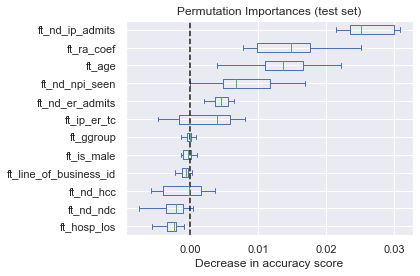

In [202]:
# feature importance from sklearn docs
# https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py
result = permutation_importance(
    gbdt, test_members[features], test_members.target, n_repeats=10, random_state=42, n_jobs=16
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=test_members[features].columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

In [203]:
valid_results = df.loc[df.is_test_set]

In [204]:
total_spend = valid_results.target.sum()
total_spend

25419409.97

In [205]:
n_30pct = int(valid_results.shape[0]*.3)

In [206]:
valid_results = valid_results.sort_values('pred', ascending=False)
top_30pct_pred_spend =  valid_results.iloc[:n_30pct].target.sum()

In [207]:
top_30pct_pred_spend / total_spend

0.5853128879686582

In [208]:
valid_results = valid_results.sort_values('target', ascending=False)
top_30pct_spend =  valid_results.iloc[:n_30pct].target.sum()
top_30pct_spend / total_spend

0.9792718402739544

In [209]:
top_30pct_pred_spend / top_30pct_spend 

0.5977021536787119